In [1]:
# import libraries
import math
import numpy
import numpy as np
import matplotlib.pyplot as plt
import sklearn.preprocessing
import itertools
import torch
import random
import time
from sklearn import preprocessing
import scipy.io

# from net import MainNet
from dynamics.robot_selector import robot_selector
from dynamics.data_gen_robot import data_gen_robot_multi

In [2]:
robot_type = "3R"
modality = "3D"

In [3]:
# robot pars
robot_pars = {}
robot_pars['m'] = 0.6
robot_pars['l'] = 1
robot_pars['I'] = (robot_pars['m']/(robot_pars['l']**2))*np.diag([0,1,1])/12
robot_pars['G'] = 1
robot_pars['B'] = 0
robot_pars['T'] = 0

In [4]:
# robot parameters changed
robot_pars_changed = {}
robot_pars_changed['m'] = 0.6+(-5*0.06)
robot_pars_changed['l'] = 1.0   # 1
robot_pars_changed['I'] = (robot_pars_changed['m']/(robot_pars_changed['l']**2))*np.diag([0,1,1])/12
robot_pars_changed['G'] = 1
robot_pars_changed['B'] = 0
robot_pars_changed['T'] = 0

robot_pars_changed['state_noise'] = True
robot_pars_changed['state_noise_type'] = 'gaussian' # constant, sinosoidal, gaussian, 'random'
SNR_DB_state = 25
robot_pars_changed ['SN_state'] = (10**(SNR_DB_state/20))

robot_pars_changed ['ext_torque'] = False
SNR_DB_input = 10
robot_pars_changed ['ext_torque_type'] = 'gaussian' # constant, sinosoidal, gaussian, 'random'
robot_pars_changed ['SN_input'] = (10**(SNR_DB_input/20))

In [5]:
robot_name = robot_type + "_" + modality
robot = robot_selector(robot_name,robot_pars)
robot_changed = robot_selector(robot_name,robot_pars_changed)

In [6]:
dt = 0.01  #time step
num_train = 120  # no. of training examples
num_val = int(0.25 * num_train)  # no of testing examples
num_traj = num_train + num_val  #no of trajectories
num_snaps = 100  # no. of snapshots
controller = 'controller'  # controller used or not for data generation
num_joints = robot.random_q().shape[0]
num_states = 2 * robot.random_q().shape[0]
num_inputs = num_joints

T = np.linspace(0, num_snaps * dt, num_snaps)

In [7]:
state_data,_, _, _, input_data = data_gen_robot_multi(dt,num_traj,num_snaps, robot, robot_changed, robot_pars_changed, controller)

In [8]:
state_data.shape, input_data.shape

((150, 100, 6), (150, 99, 3))

In [9]:
accln = (state_data[:,1:,num_joints:] - state_data[:,:-1,num_joints:])/dt

In [10]:
accln.shape

(150, 99, 3)

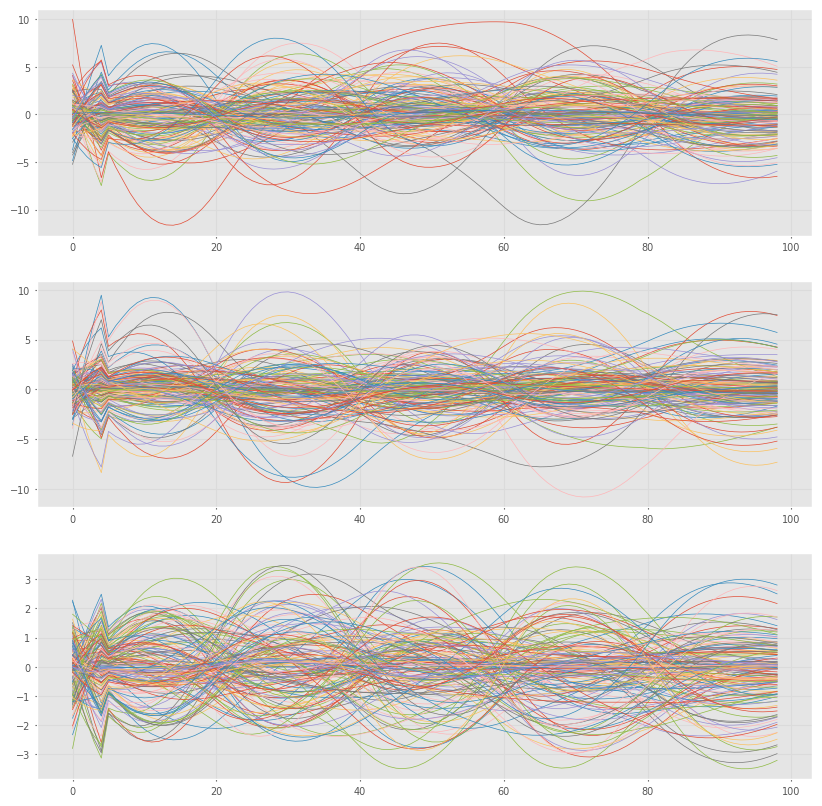

In [11]:
plt.figure(figsize = (10,10))
for i in range(num_traj):
    for j in range(num_joints):
        plt.subplot(3,1,j+1)
        plt.plot(accln[i,:,j])
plt.show()

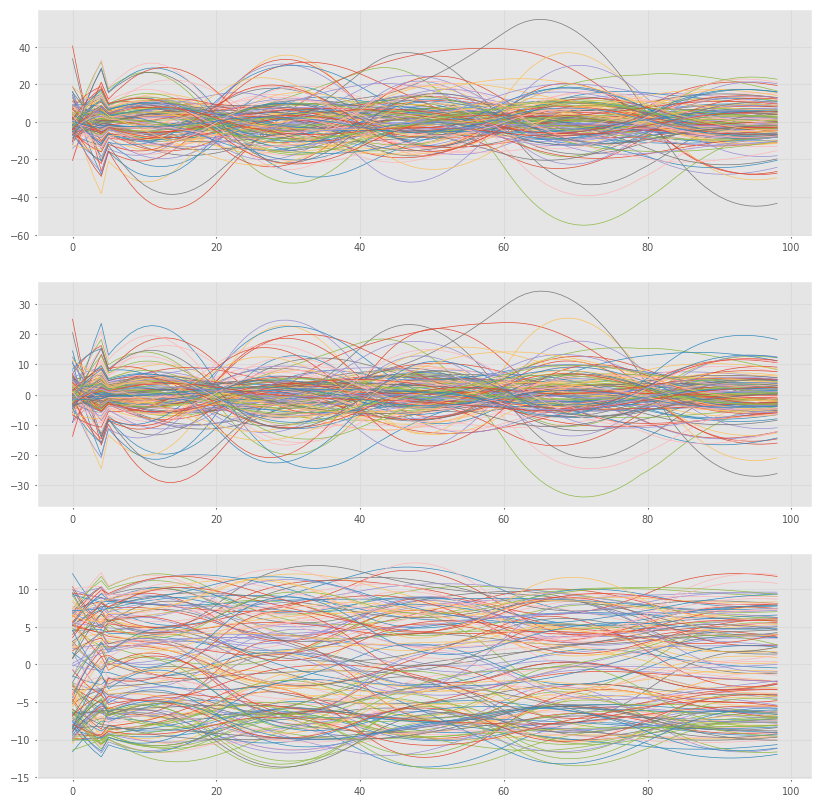

In [12]:
plt.figure(figsize = (10,10))
for i in range(num_traj):
    for j in range(num_joints):
        plt.subplot(3,1,j+1)
        plt.plot(input_data[i,:,j])
plt.show()

In [13]:
#define network parameters
FC_neurons = 100
Conv_RELU = 100
Conv = 200
net_params = {}
net_params['num_joints'] = num_joints
net_params["input_dim"] = num_states
net_params['output_dim'] = num_inputs
net_params['num_steps'] = 100
net_params["beta"] = 0.95

net_params['FC_layers'] = [FC_neurons, FC_neurons, num_joints]
net_params['Conv_layers_RELU'] = [3, Conv_RELU, [1, 1]] # [in_channels, out_channels, kernel_size (height), width]
net_params['Conv_layers'] = [Conv_RELU, Conv, [1, 1]]
net_params['dim_layer_a'] = Conv
net_params['optimizer'] = 'adam'
net_params['l1_reg'] = 2e-1
net_params['l2_reg'] = 2e-1
net_params['lr'] = 1e-3
net_params['epochs'] = 10
net_params['batch_size'] = 256

In [14]:
X = np.concatenate((state_data[:,:-1,:], accln), axis = 2)

In [16]:
xs_train, us_train = X[:num_train,:,:], input_data[:num_train,:,:]
xs_val, us_val = X[num_train:,:,:], input_data[num_train:,:,:]

In [17]:
xs_train.shape, us_train.shape

((120, 99, 9), (120, 99, 3))

In [18]:
from snn_net import RateEncoder, RateDecoder, SNNRegressor, train_snn_regressor, evaluate_snn_regressor
from torch.utils.data import DataLoader, TensorDataset
import hiddenlayer as hl
from core.util import fit_standardizer

In [19]:
xs_train.shape, us_train.shape

((120, 99, 9), (120, 99, 3))

In [20]:
def process_data(data_x, data_u, net_params):
    n = net_params['num_joints']
    m = net_params['output_dim']
    N = net_params['input_dim']

    order = 'F'
    n_data_pts = data_x.shape[0] * (data_x.shape[1])
    x_flat = data_x.T.reshape((3*n, n_data_pts), order = order).T
    u_flat = data_u.T.reshape((m, n_data_pts), order = order).T

    x_torch = torch.from_numpy(x_flat)
    u_torch = torch.from_numpy(u_flat)

    # u_min = torch.min(u_torch, dim=0, keepdim = True)[0]
    # u_max = torch.max(u_torch, dim=0, keepdim = True)[0]
    # u_range = u_max - u_min
    # u_range = torch.where(u_range == 0, torch.ones_like(u_range), u_range)
    # u = (u_torch - u_min)/u_range
    return x_torch.float(), u_torch.float()
    

In [22]:
x_train_flat, u_train_flat = process_data(xs_train, us_train, net_params)
x_val_flat, u_val_flat = process_data(xs_val, us_val, net_params)

In [23]:
x_train_flat.shape, u_train_flat.shape

(torch.Size([11880, 9]), torch.Size([11880, 3]))

In [24]:
x_val_flat.shape, u_val_flat.shape

(torch.Size([2970, 9]), torch.Size([2970, 3]))

In [25]:
model = SNNRegressor(net_params)

In [26]:
print(model)

SNNRegressor(
  (fc1): Linear(in_features=6, out_features=100, bias=True)
  (lif1): Leaky()
  (fc2): Linear(in_features=100, out_features=100, bias=True)
  (lif2): Leaky()
  (fc3): Linear(in_features=100, out_features=3, bias=True)
  (lif3): Leaky()
  (conv1): Conv2d(3, 100, kernel_size=(1, 1), stride=(1, 1))
  (lif4): Leaky()
  (conv2): Conv2d(100, 200, kernel_size=(1, 1), stride=(1, 1))
  (fc_A): Linear(in_features=200, out_features=1, bias=False)
  (max_pool1): MaxPool2d(kernel_size=1, stride=1, padding=0, dilation=1, ceil_mode=False)
  (max_pool2): MaxPool2d(kernel_size=1, stride=1, padding=0, dilation=1, ceil_mode=False)
)


In [27]:
train_dataset = TensorDataset(x_train_flat, u_train_flat)
val_dataset = TensorDataset(x_val_flat, u_val_flat)
train_loader = DataLoader(train_dataset, batch_size=net_params['batch_size'], shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=net_params['batch_size'], shuffle=False)

In [28]:
print(f"Training data: {len(train_dataset)} samples")
print(f"Test data: {len(val_dataset)} samples")
print(f"Sample input shape: {x_train_flat[0].shape}")
print(f"Sample target shape: {u_train_flat[0].shape}")

Training data: 11880 samples
Test data: 2970 samples
Sample input shape: torch.Size([9])
Sample target shape: torch.Size([3])


In [29]:
train_losses, val_losses = train_snn_regressor(
    model, train_loader, val_loader, 
    net_params['epochs'], net_params['lr']
)

Training on device: cpu
Model parameters: 31903
Epoch [1/10], Batch [0], Loss: 70.986229
Epoch [1/10], Train Loss: 64.010011, Test Loss: 51.728595
Epoch [2/10], Batch [0], Loss: 58.925159
Epoch [2/10], Train Loss: 64.083049, Test Loss: 51.713498
Epoch [3/10], Batch [0], Loss: 70.389778
Epoch [3/10], Train Loss: 63.942081, Test Loss: 51.724648
Epoch [4/10], Batch [0], Loss: 53.955704
Epoch [4/10], Train Loss: 63.950767, Test Loss: 51.717500
Epoch [5/10], Batch [0], Loss: 61.227680
Epoch [5/10], Train Loss: 64.104682, Test Loss: 51.723959
Epoch [6/10], Batch [0], Loss: 66.395584
Epoch [6/10], Train Loss: 63.980378, Test Loss: 51.723391
Epoch [7/10], Batch [0], Loss: 61.399338
Epoch [7/10], Train Loss: 64.052318, Test Loss: 51.732509
Epoch [8/10], Batch [0], Loss: 66.361176
Epoch [8/10], Train Loss: 63.860833, Test Loss: 51.729425
Epoch [9/10], Batch [0], Loss: 54.710464
Epoch [9/10], Train Loss: 64.044039, Test Loss: 51.736038
Epoch [10/10], Batch [0], Loss: 83.327896
Epoch [10/10], Trai


=== Visualizing Results ===


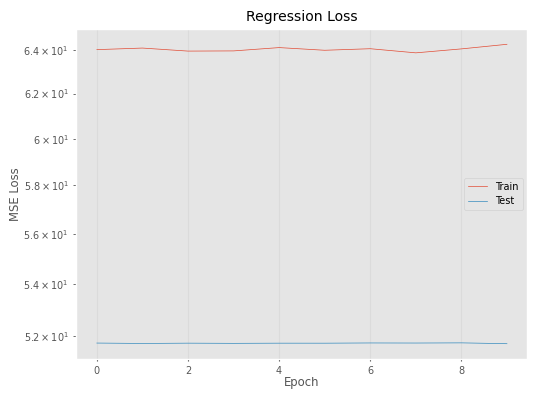

In [30]:

"""Main function to run the complete regression example"""

# Visualize results
print("\n=== Visualizing Results ===")

# Plot training curves
plt.figure(figsize=(10, 4))

plt.subplot(1, 2, 1)
plt.plot(train_losses, label='Train')
plt.plot(val_losses, label='Test')
plt.title('Regression Loss')
plt.xlabel('Epoch')
plt.ylabel('MSE Loss')
plt.legend()
plt.grid(True)
plt.yscale('log')

plt.tight_layout()
plt.show()

In [31]:
index = 9
x_test = X[index,:,:]
y_test = input_data[index,:,:]

In [32]:
x_test.shape, y_test.shape

((99, 9), (99, 3))

In [33]:
Train = False

y_net = np.zeros((num_snaps, num_joints))
x_test_flat, y_test_flat = process_data(x_test.reshape((1,-1,9)), y_test.reshape(1,-1,3), net_params)


for i in range(x_test.shape[0]):
    y_net[i,:] = model.forward(x_test_flat[i,:].reshape(1,-1), Train)

In [34]:
y_test_flat.shape

torch.Size([99, 3])

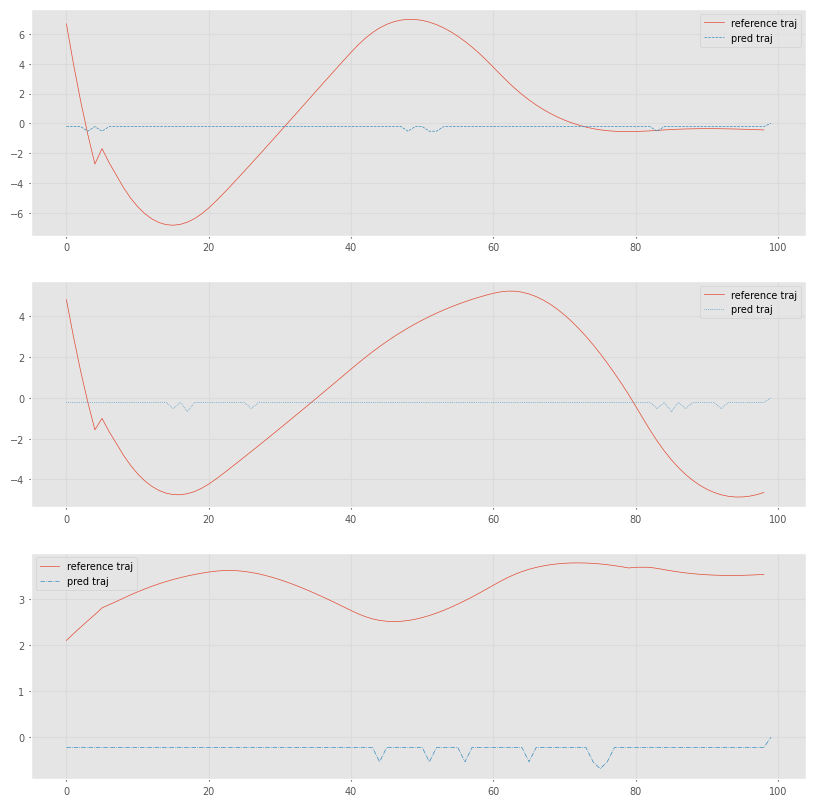

In [35]:
plt.figure(figsize = (10,10))
plt.subplot(3,1,1)
plt.plot(y_test_flat[:,0], label = 'reference traj')
plt.plot(y_net[:,0],'--', label = 'pred traj')
plt.legend()

plt.subplot(3,1,2)
plt.plot(y_test_flat[:,1], label = 'reference traj')
plt.plot(y_net[:,1],':', label = 'pred traj')
plt.legend()

plt.subplot(3,1,3)
plt.plot(y_test_flat[:,2], label = 'reference traj')
plt.plot(y_net[:,2],'-.', label = 'pred traj')
plt.legend()
plt.show()

In [36]:
"""CONTROL AND ADAPTATION"""

'CONTROL AND ADAPTATION'

In [37]:
#Define reference trajectory
dt = 0.01
t_end = 10
t_eval = np.arange(0,t_end,dt)
num_steps = t_eval.shape[0]
theta_d = np.zeros((num_steps, num_joints))
theta_dot_d = np.zeros((num_steps, num_joints))
theta_ddot_d = np.zeros((num_steps, num_joints))

num_cycles = t_end/10
arg = np.linspace(0, num_cycles*2*np.pi,num_steps)


for i in range(num_steps):
    theta_d[i,:] = -0.5*np.array([np.sin(2*arg[i]), np.sin(2*arg[i]), np.sin(2*arg[i])])

    theta_dot_d[i,:] = -0.5*np.array([(2*arg[-1]/t_end)*np.cos(2*arg[i]), (2*arg[-1]/t_end)*np.cos(2*arg[i]), (2*arg[-1]/t_end)*np.cos(2*arg[i])])

    theta_ddot_d[i,:] = -0.5*np.array([-((2*arg[-1]/t_end)**2)*np.cos(2*arg[i]), -((2*arg[-1]/t_end)**2)*np.cos(2*arg[i]), -((2*arg[-1]/t_end)**2)*np.cos(2*arg[i])])


tau = np.zeros((num_steps, num_joints))

theta_t = np.zeros_like(theta_d)
theta_dot_t = np.zeros_like(theta_dot_d)
theta_ddot_t = np.zeros_like(theta_dot_d)

Error = np.zeros((num_steps,num_joints))
Error_dot = np.zeros((num_steps, num_joints))

a = np.zeros((Conv,num_steps))
a[:,0] = model.fc_A.weight.detach().numpy().reshape(-1)

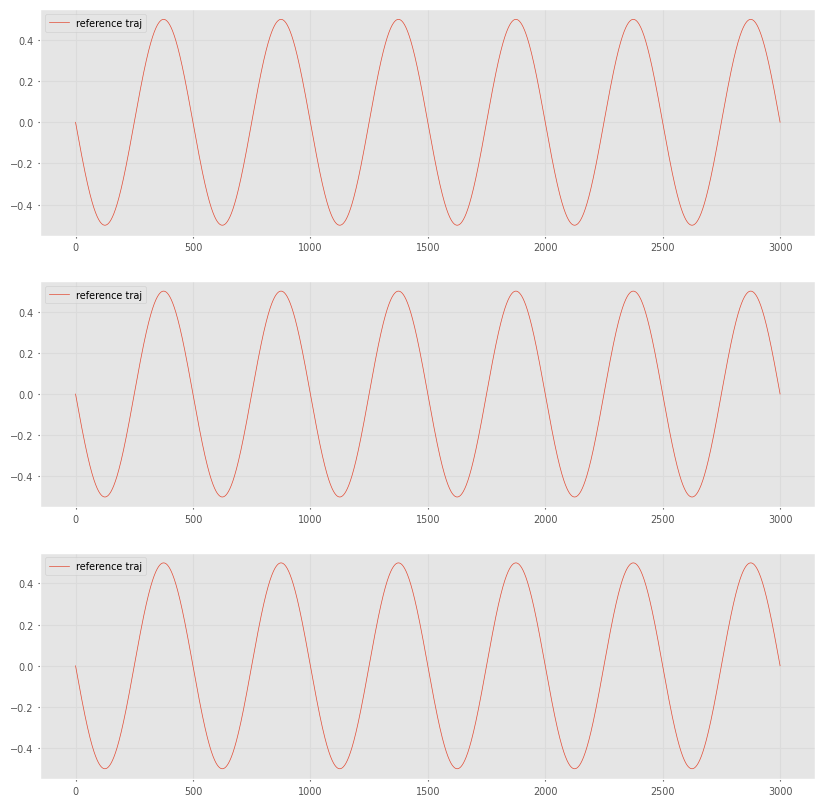

In [38]:
plt.figure(figsize = (10,10))
plt.subplot(3,1,1)
plt.plot(theta_d[:,0], label = 'reference traj')
plt.legend()

plt.subplot(3,1,2)
plt.plot(theta_d[:,1], label = 'reference traj')
plt.legend()

plt.subplot(3,1,3)
plt.plot(theta_d[:,2], label = 'reference traj')
plt.legend()
plt.show()

In [39]:
# Simultaneous adaptation and control
k = 9
P = 0.01
Ks = np.diag(np.array([0.1, 0.1, 0.1]))
L = np.diag(np.array([2, 2, 2]))

adapt_freq = 500
# train_network = torch.load('NN_arch.pth')


for i in range(num_steps-1):
    t1 = time.time()
    error = (theta_t[i,:] - theta_d[i,:]).reshape(-1,1)
    error_dot = (theta_dot_t[i,:] - theta_dot_d[i,:]).reshape(-1,1)
    s =  error_dot + L @ error
    theta_dot_r = theta_dot_d[i,:].reshape(-1,1) - L @ error
    theta_ddot_r = theta_ddot_d[i,:].reshape(-1,1) - L @ error_dot

    input_vec = np.concatenate((theta_t[i,:],theta_dot_t[i,:], theta_dot_r.reshape(-1,), theta_ddot_r.reshape(-1,)))

    input_vec_tensor = torch.from_numpy(input_vec.reshape(1,-1)).float()
    Y_out = model.Y_out(input_vec_tensor)
    a_dot = -P * Y_out.squeeze() @ s

    tau[i,:] = (Y_out.squeeze().T @ a[:,i].reshape(-1,1) - Ks @ s - k * np.sign(s)).reshape(-1,)

    a[:,i+1] = a[:,i] + a_dot.reshape(-1,) * dt

    theta_ddot_t[i,:] = robot_changed.accel(theta_t[i,:], theta_dot_t[i,:], tau[i,:]).reshape(-1,)
    theta_dot_t[i+1,:] = theta_ddot_t[i,:] * dt + theta_dot_t[i,:]
    theta_t[i+1,:] = theta_t[i,:] + theta_dot_t[i+1,:]*dt
    
    Error[i,:] = error.reshape(-1,)
    Error_dot[i,:] = error_dot.reshape(-1,)


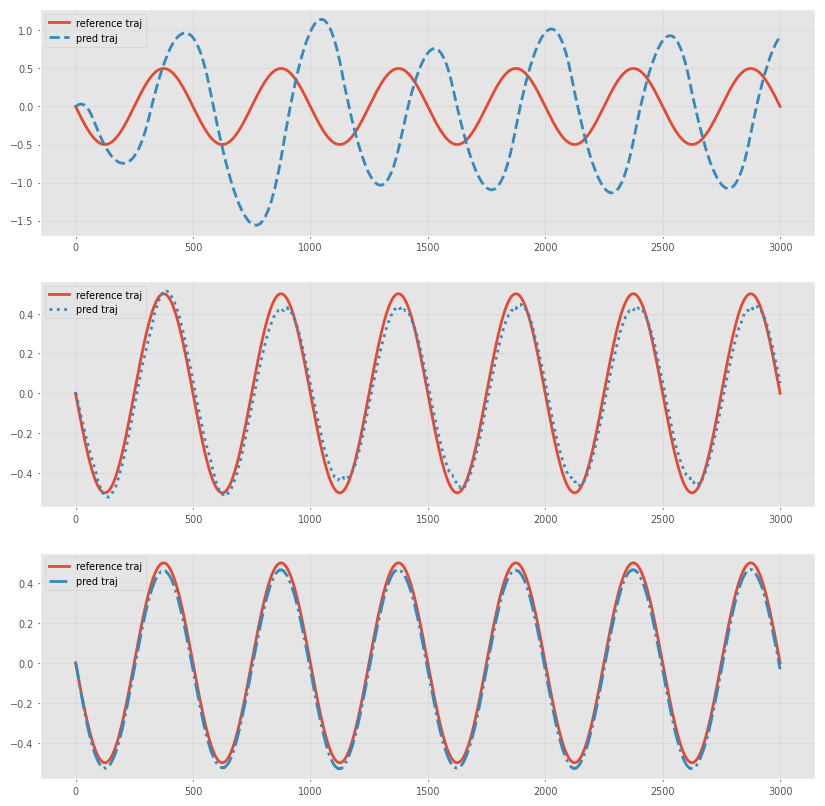

In [41]:
plt.figure(figsize = (10,10))
plt.subplot(3,1,1)
plt.plot(theta_d[:,0], linewidth = 2, label = 'reference traj')
plt.plot(theta_t[:,0],'--',linewidth = 2, label = 'pred traj')
plt.legend()

plt.subplot(3,1,2)
plt.plot(theta_d[:,1],linewidth = 2, label = 'reference traj')
plt.plot(theta_t[:,1],':',linewidth = 2, label = 'pred traj')
plt.legend()

plt.subplot(3,1,3)
plt.plot(theta_d[:,2],linewidth = 2, label = 'reference traj')
plt.plot(theta_t[:,2],'-.',linewidth = 2, label = 'pred traj')
plt.legend()
plt.show()

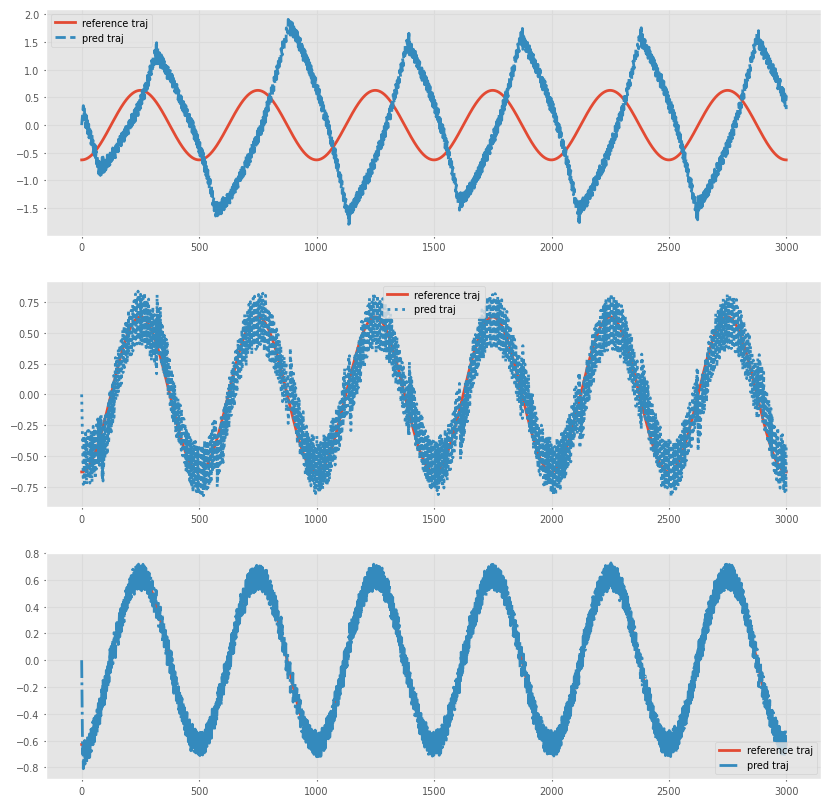

In [42]:
plt.figure(figsize = (10,10))
plt.subplot(3,1,1)
plt.plot(theta_dot_d[:,0], linewidth = 2, label = 'reference traj')
plt.plot(theta_dot_t[:,0],'--',linewidth = 2, label = 'pred traj')
plt.legend()

plt.subplot(3,1,2)
plt.plot(theta_dot_d[:,1],linewidth = 2, label = 'reference traj')
plt.plot(theta_dot_t[:,1],':',linewidth = 2, label = 'pred traj')
plt.legend()

plt.subplot(3,1,3)
plt.plot(theta_dot_d[:,2],linewidth = 2, label = 'reference traj')
plt.plot(theta_dot_t[:,2],'-.',linewidth = 2, label = 'pred traj')
plt.legend()
plt.show()

In [ ]:
plt.figure(figsize = (15,5))
plt.plot(Error, label = 'error')

In [ ]:
plt.figure(figsize = (20,10))
plt.subplot(3,1,1)
plt.plot(tau[:,0], linewidth = 1, label = 'u1')
plt.legend()

plt.subplot(3,1,2)
plt.plot(tau[:,1],linewidth = 1, label = 'u2')
plt.legend()

plt.subplot(3,1,3)
plt.plot(tau[:,2],linewidth = 1, label = 'u3')
plt.legend()
plt.show()

In [ ]:
error_adapt = np.linalg.norm((theta_t-theta_d),axis=1)

In [ ]:
error_adapt.shape

In [ ]:
error_adapt_rmse = np.linalg.norm(error_adapt)/np.sqrt(t_eval.shape[0])

print("RMSE theta Error in Adaptive Model", error_adapt_rmse)


In [ ]:
error_adapt_dot = np.linalg.norm((theta_dot_t-theta_dot_d),axis=1)
error_adapt_rmse_dot = np.linalg.norm(error_adapt_dot)/np.sqrt(t_eval.shape[0])

print("RMSE theta dot Error in Adaptive Model", error_adapt_rmse_dot)

In [ ]:
# RMSE_130 = np.array([error_adapt_rmse])
# np.savetxt('RMSE_130.txt', RMSE_130, delimiter=',')

In [ ]:
control_effort = np.linalg.norm((tau), axis = 1)

In [ ]:
control_effort.shape

In [ ]:
average_control_effort = np.sum(control_effort)/num_steps

In [ ]:
average_control_effort

In [ ]:
traj_adapt = {"error_theta_adapt":(theta_t-theta_d)}
scipy.io.savemat("changed_results/" + 'num_traj'+str(num_train)+"adapt_CNN_error.mat",traj_adapt)